In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
# import lightgbm as lgb
# import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
# Standard plotly imports
# import plotly.plotly as py
# import plotly.graph_objs as go
# import plotly.tools as tls
# from plotly.offline import iplot, init_notebook_mode
# import cufflinks
# import cufflinks as cf
# import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
# init_notebook_mode(connected=True)
# cufflinks.go_offline(connected=True)
import multiprocessing
import datetime

import warnings
warnings.filterwarnings("ignore")

import gc
# 启用自动垃圾回收
gc.enable() 
import os
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

In [2]:
print('# File sizes')
for f in os.listdir('data'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')

# File sizes
test_transaction.csv          613.19MB
train_identity.csv            26.53MB
test_identity.csv             25.8MB
sample_submission.csv         6.08MB
train_transaction.csv         683.35MB


In [3]:
%%time
train_transaction = pd.read_csv('data/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('data/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('data/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('data/test_identity.csv', index_col='TransactionID')
print ("Data is loaded!")

Data is loaded!
CPU times: user 36.3 s, sys: 5.58 s, total: 41.9 s
Wall time: 42.4 s


In [4]:
%%time

files = ['data/test_identity.csv', 
         'data/test_transaction.csv',
         'data/train_identity.csv',
         'data/train_transaction.csv']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_identity, test_transaction, train_identity, train_transaction = pool.map(load_data, files)

CPU times: user 3.71 s, sys: 8 s, total: 11.7 s
Wall time: 35.7 s


In [6]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)
train_identity shape is (144233, 40)
test_identity shape is (141907, 40)


In [7]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.

In [8]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## EDA

### `NaN` Value

> 并不是所有的交易都有相应的identity信息

In [9]:
missing_values_count = train_transaction.isnull().sum()
print(missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print("% of missing data = ",(total_missing/total_cells) * 100)

isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
card6             1571
dtype: int64
% of missing data =  41.17794374769424


In [10]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_01         0
id_02      3361
id_03     77909
id_04     77909
id_05      7368
id_06      7368
id_07    139078
id_08    139078
id_09     69307
id_10     69307
dtype: int64
% of missing data =  36.47062392101669


In [11]:
del missing_values_count, total_cells, total_missing

### Imbalanced

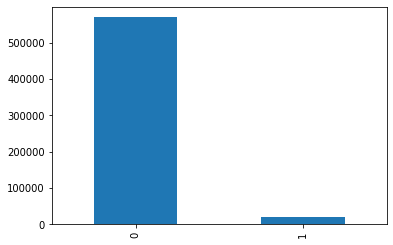

In [26]:
train_transaction['isFraud'].value_counts().plot('bar')

### Time vs fe

```
Train: min = 86400 max = 15811131
Test: min = 18403224 max = 34214345

x = 34214345 - 86400 = 34127945

x/(3600*24*365) = 1.0821 years
```

In [12]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction.index.isin(train_identity.index.unique())))
print(np.sum(test_transaction.index.isin(test_identity.index.unique())))

144233
141907


- `24.4%` of TransactionIDs in train (144233 / 590540) have an associated train_identity.
- `28.0%` of TransactionIDs in test (144233 / 590540) have an associated train_identity.

In [13]:
train_transaction['TransactionDT'].head()

TransactionID
2987000    86400
2987001    86401
2987002    86469
2987003    86499
2987004    86506
Name: TransactionDT, dtype: int64

In [14]:
train_transaction['TransactionDT'].shape[0] , train_transaction['TransactionDT'].nunique()

(590540, 573349)

### Train vs Test are Time Series Split

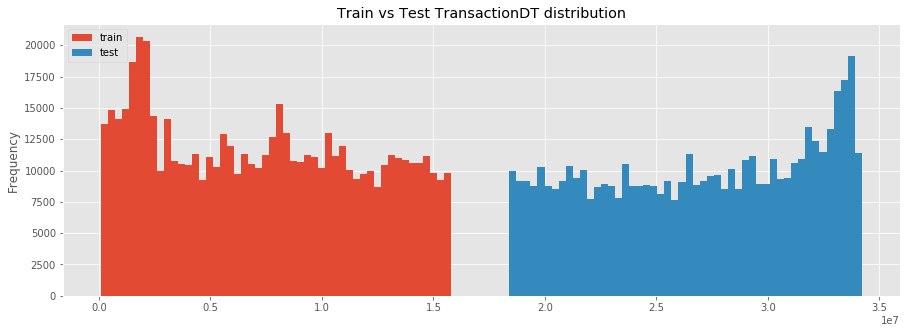

In [33]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

In [70]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train_transaction['TransactionDT'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test_transaction['TransactionDT'] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))


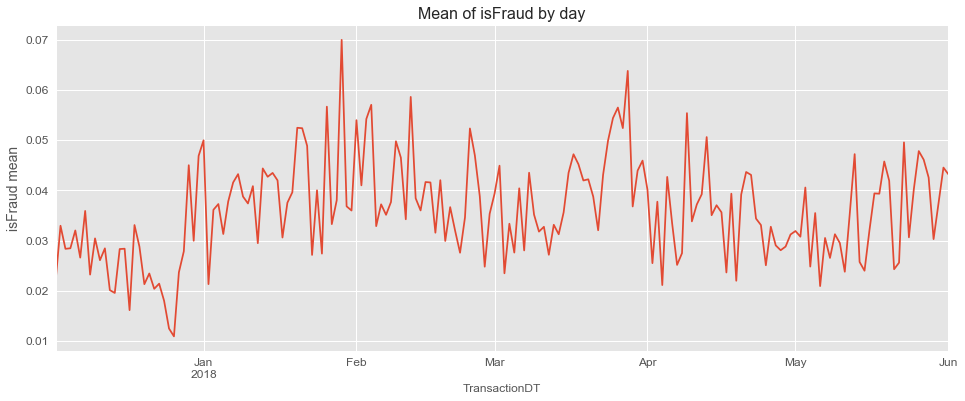

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train_transaction.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('Mean of isFraud by day', fontsize=16);


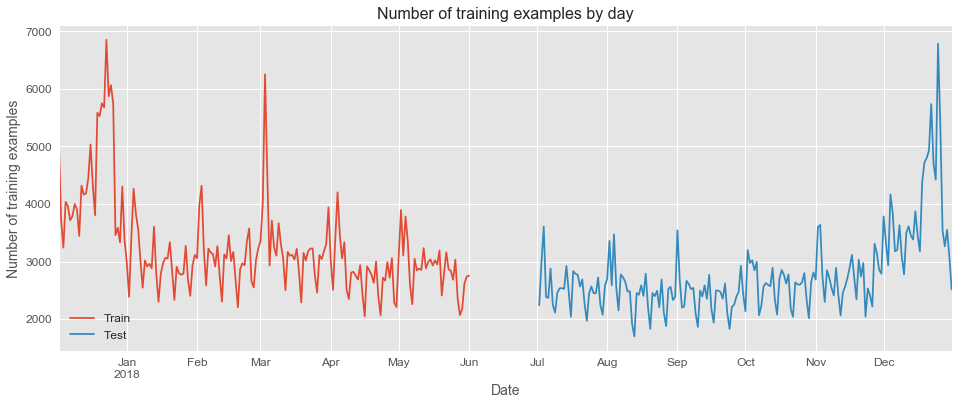

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train_transaction['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test_transaction['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of training examples', fontsize=14);
axes.set_title('Number of training examples by day', fontsize=16);
axes.legend(['Train', 'Test']);

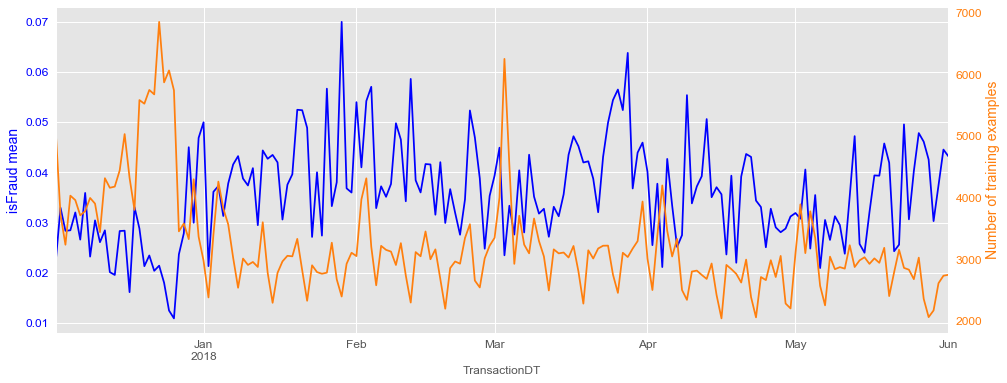

In [77]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train_transaction.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('isFraud mean', color='blue', fontsize=14)
ax2 = ax1.twinx()
train_transaction['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=ax2, color='tab:orange');
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('Number of training examples', color='tab:orange', fontsize=14);
ax2.grid(False)

### C features: C1, C2 ... C14

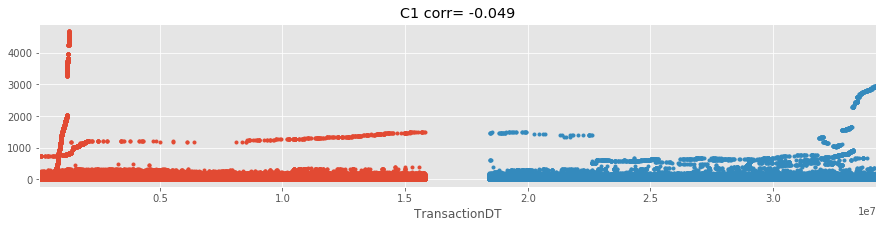

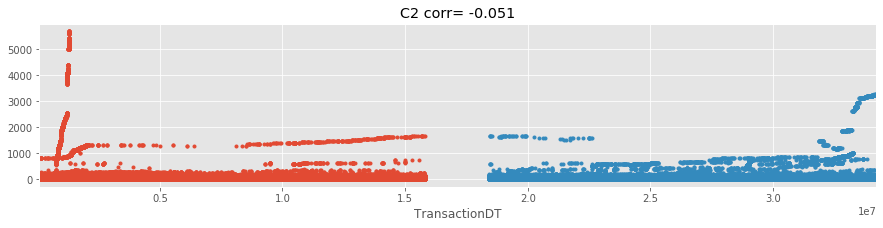

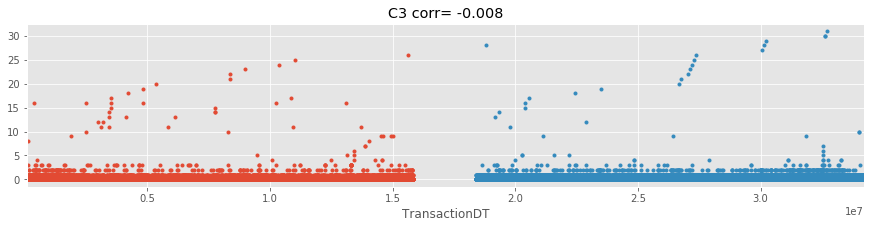

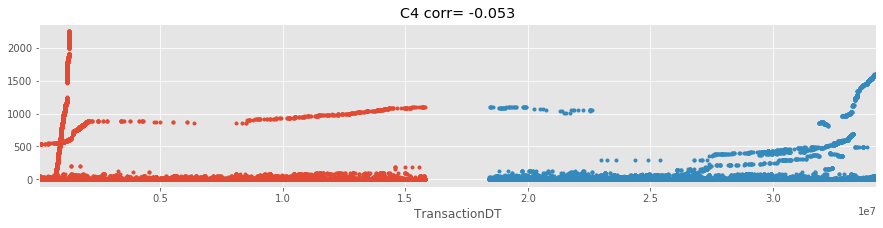

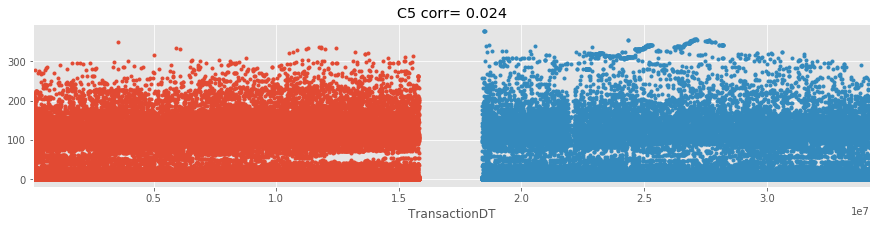

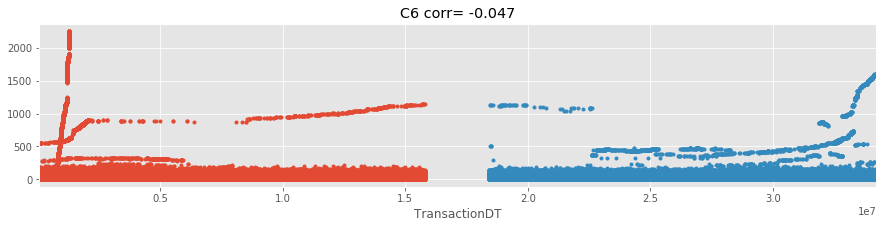

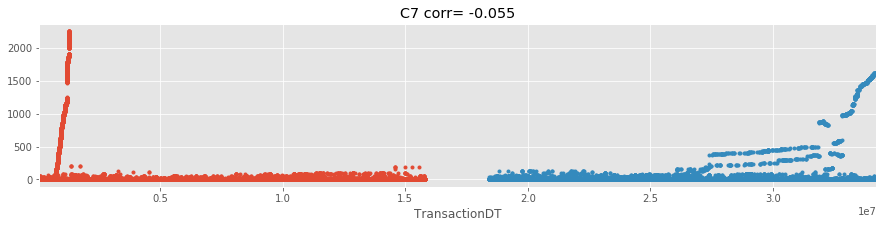

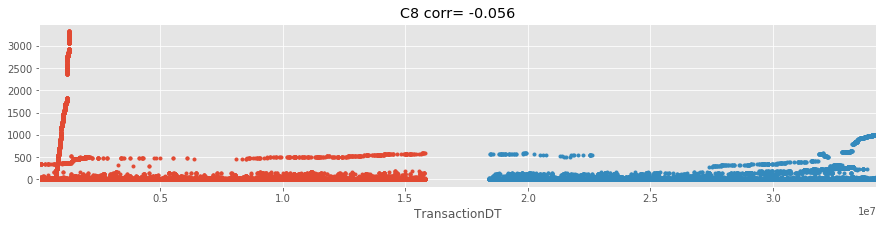

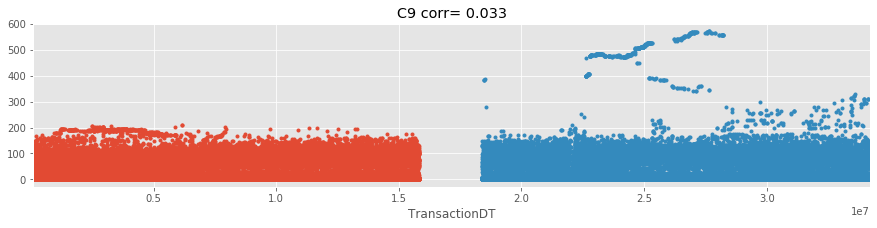

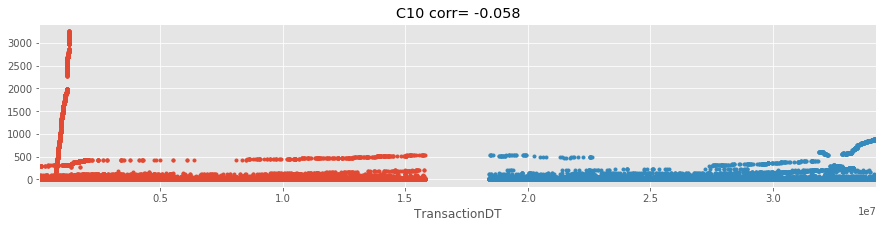

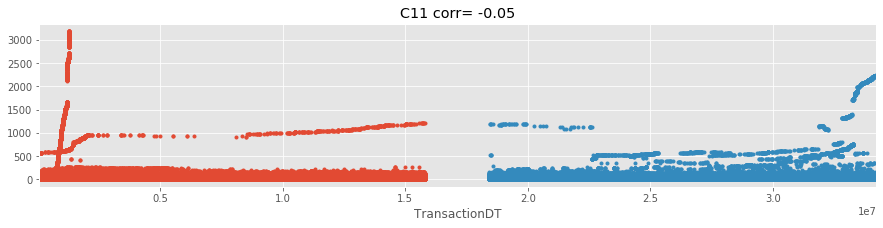

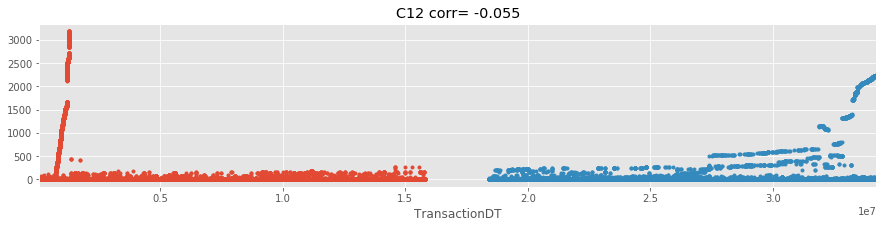

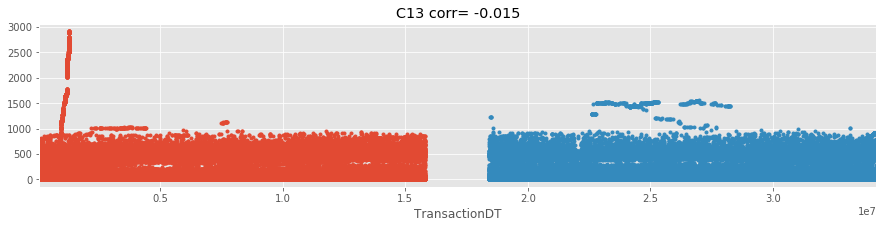

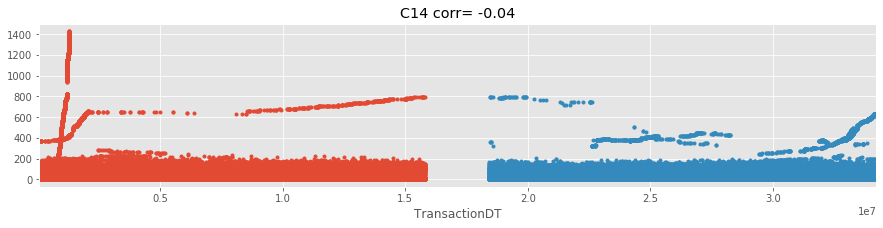

In [35]:
c_features = list(train_transaction.columns[16:30])
for i in c_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

### D features: D1 ... D15

In [39]:
# Click output to see the number of missing values in each column
missing_values_count = train_transaction[d_features].isnull().sum()
missing_values_count

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64

In [40]:
# how many total missing values do we have?
total_cells = np.product(train_transaction[d_features].shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
(total_missing/total_cells) * 100

58.15126268612908

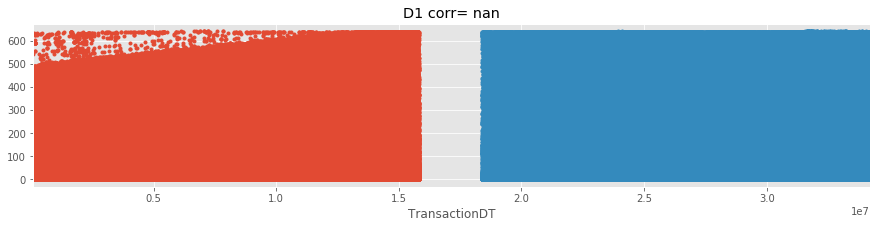

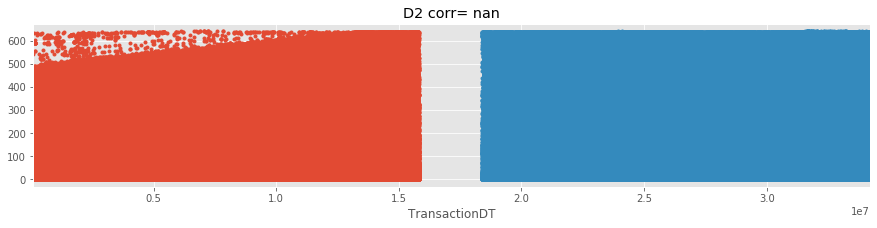

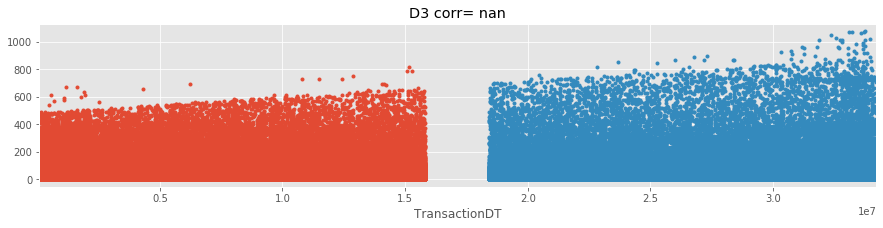

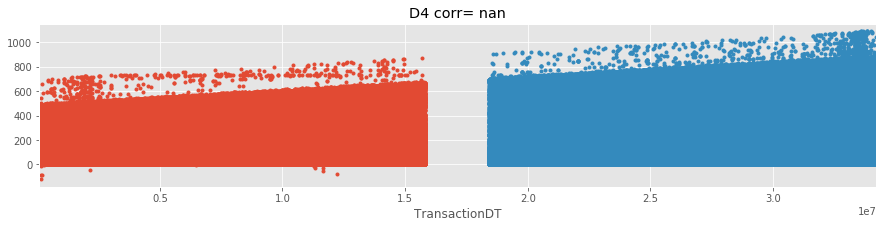

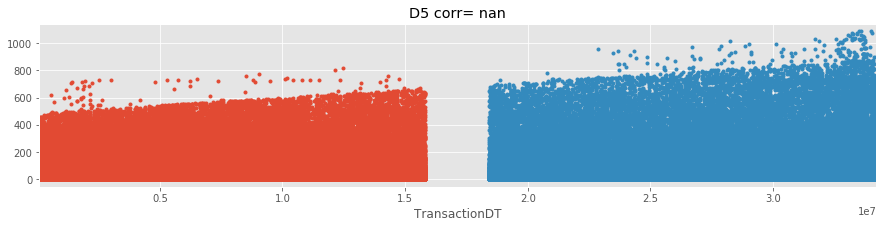

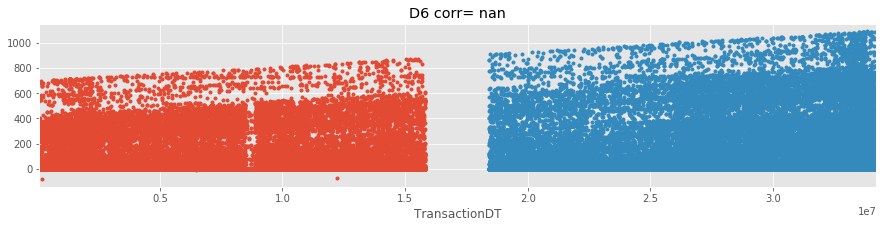

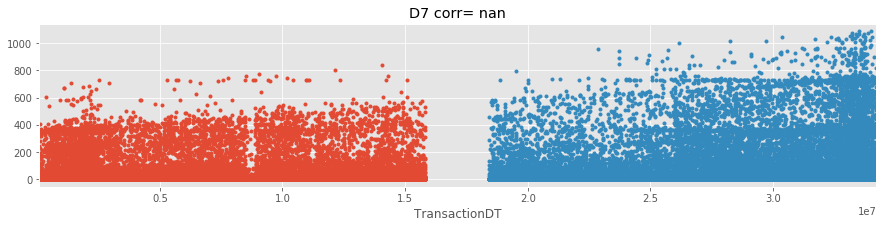

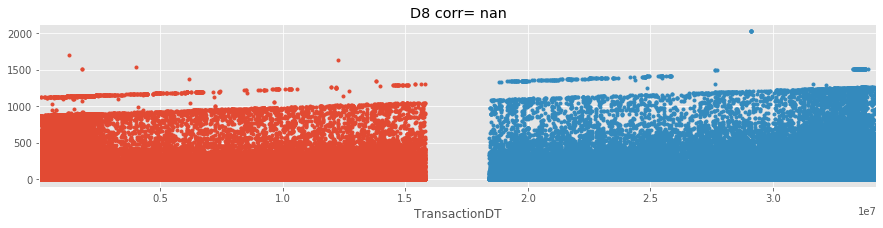

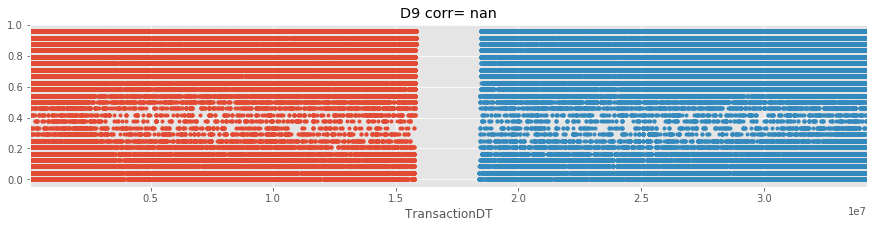

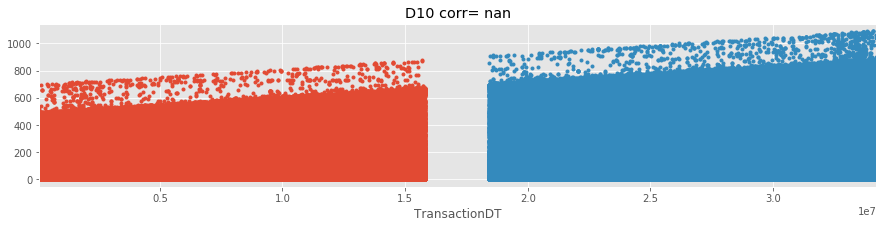

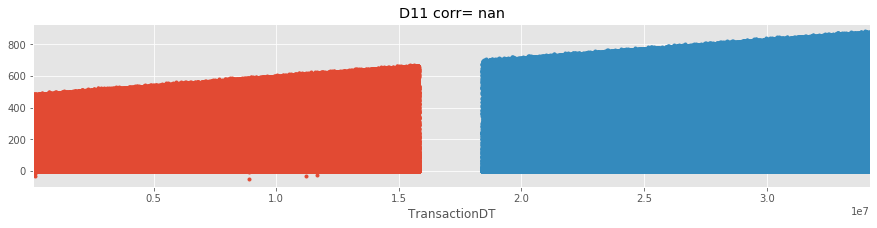

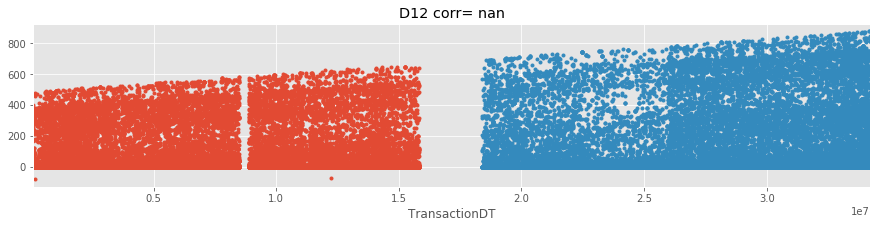

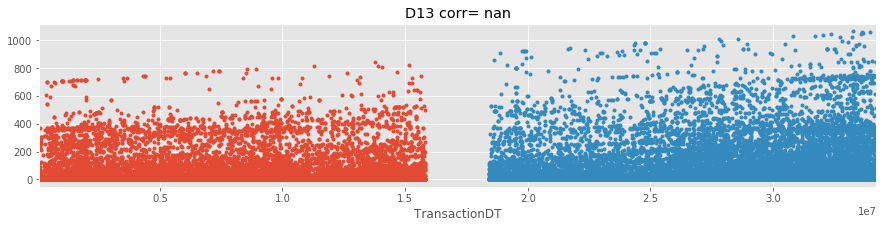

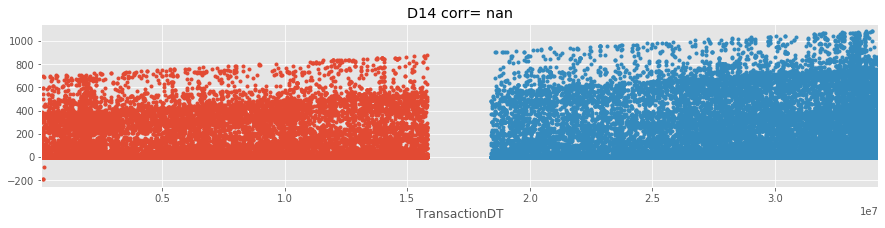

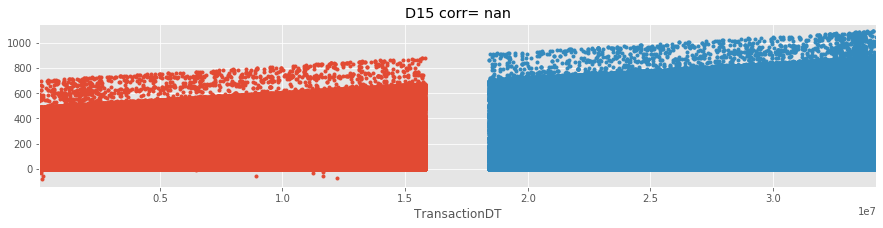

In [38]:
d_features = list(train_transaction.columns[30:45])

for i in d_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

### M features: M1 .. M9

In [41]:
m_features = list(train_transaction.columns[45:54])
train_transaction[m_features].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,NaN,NaN,NaN
2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2987002,T,T,T,M0,F,F,F,F,F
2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### V150

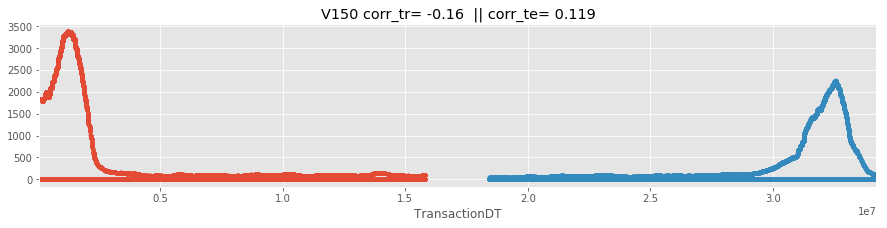

In [16]:
i = "V150"
cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
plt.show()

### Feature `V` 

> NaN values

In [17]:
train_transaction.loc[:,train_transaction.columns[train_transaction.columns.str.startswith('V')]].isnull().sum().head(20)


V1     279287
V2     279287
V3     279287
V4     279287
V5     279287
V6     279287
V7     279287
V8     279287
V9     279287
V10    279287
V11    279287
V12     76073
V13     76073
V14     76073
V15     76073
V16     76073
V17     76073
V18     76073
V19     76073
V20     76073
dtype: int64

### TransactionAmt

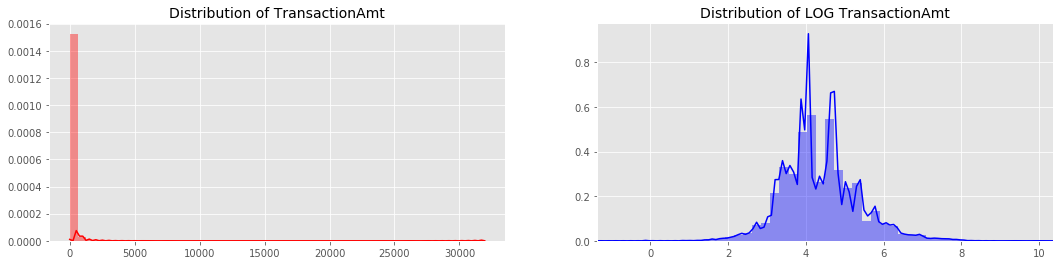

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

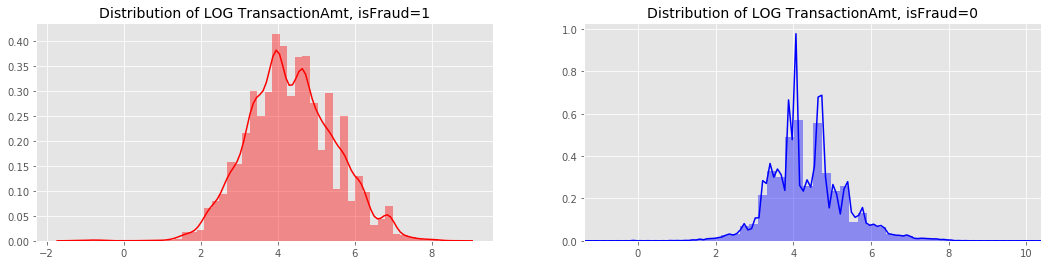

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionAmt, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

## Unique Values

### `D` Features

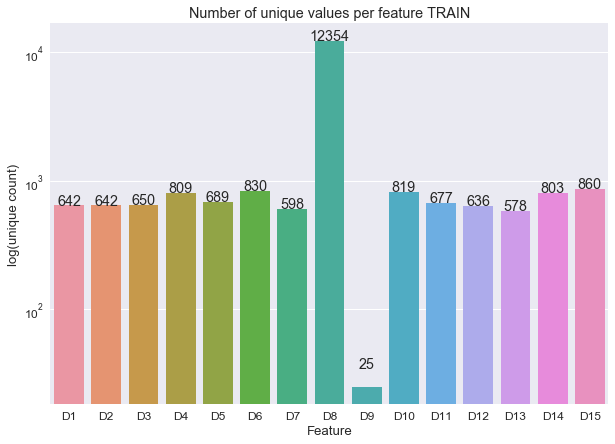

In [22]:
plt.figure(figsize=(10, 7))
d_features = list(train_transaction.columns[30:45])
uniques = [len(train_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

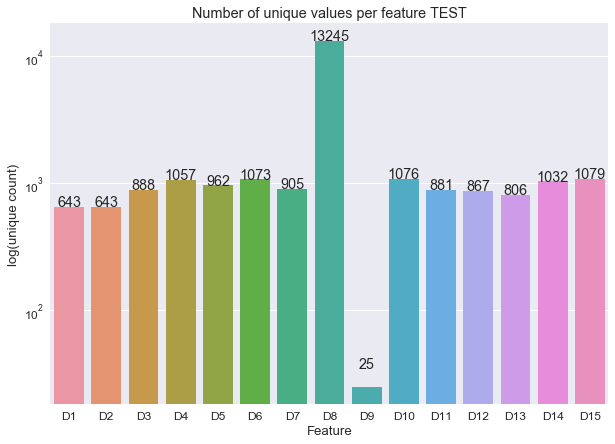

In [24]:
plt.figure(figsize=(10, 7))
d_features = list(test_transaction.columns[29:44])
uniques = [len(test_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### `C` Features

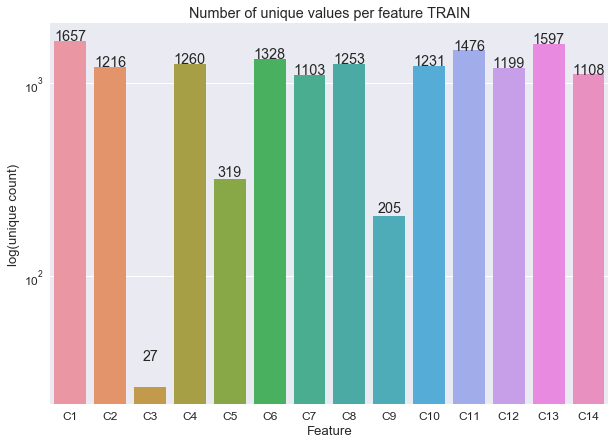

In [25]:
plt.figure(figsize=(10, 7))
c_features = list(train_transaction.columns[16:30])
uniques = [len(train_transaction[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

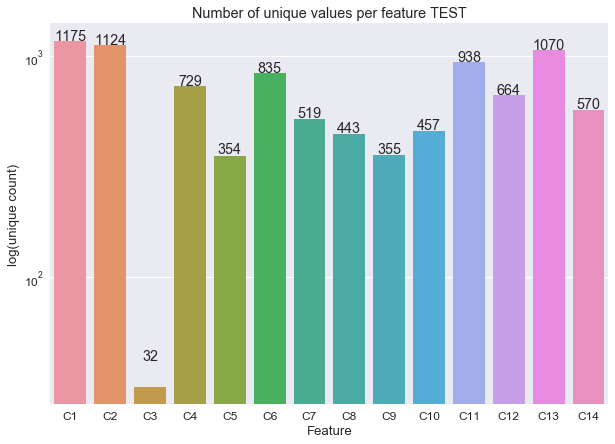

In [27]:
plt.figure(figsize=(10, 7))
c_features = list(test_transaction.columns[15:29])
uniques = [len(test_transaction[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### `V` Features

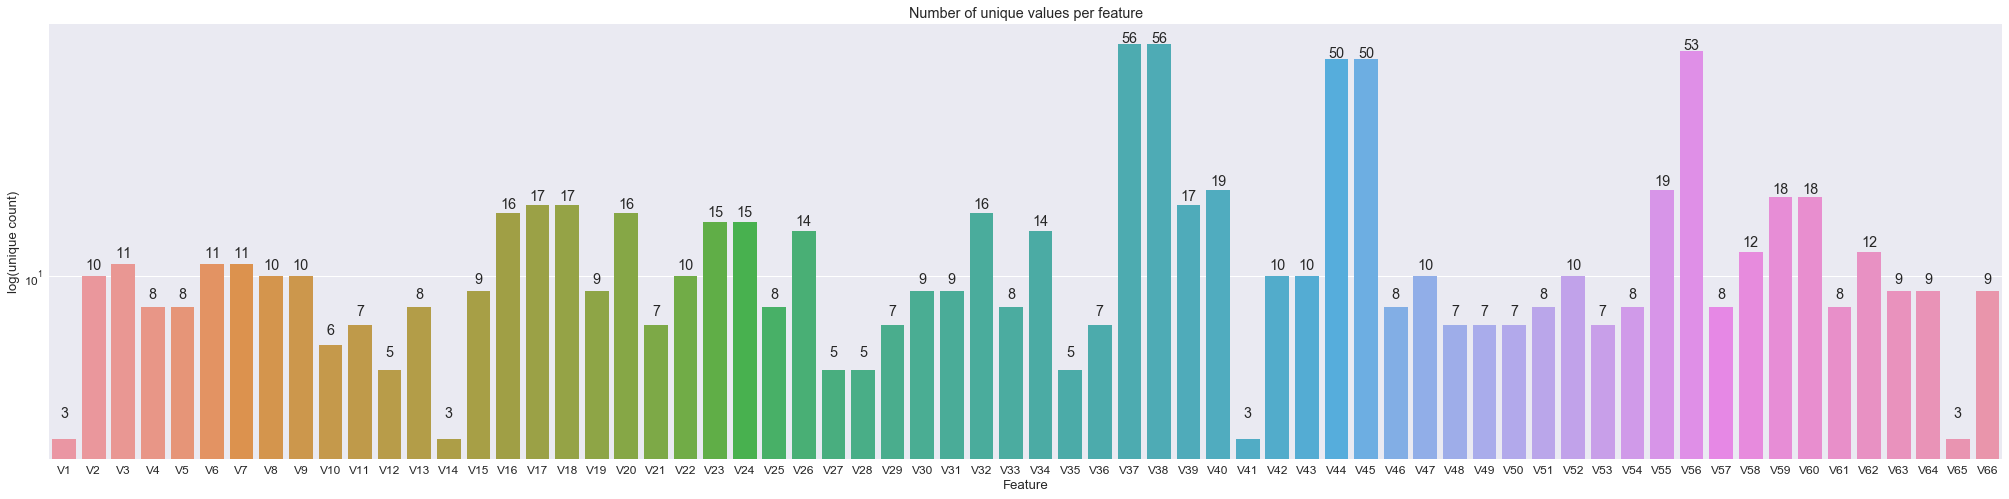

In [30]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[54:120])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            uniq,
            ha="center") 

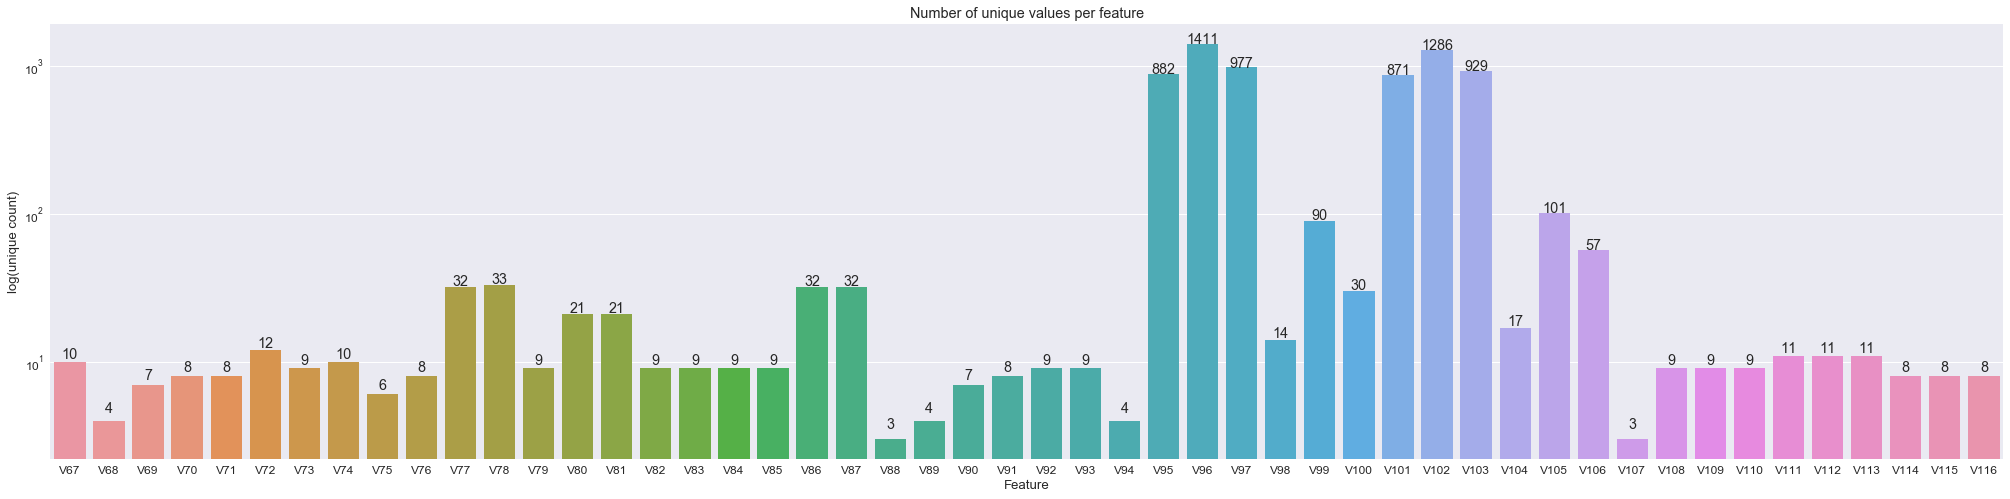

In [31]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[120:170])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            uniq,
            ha="center") 

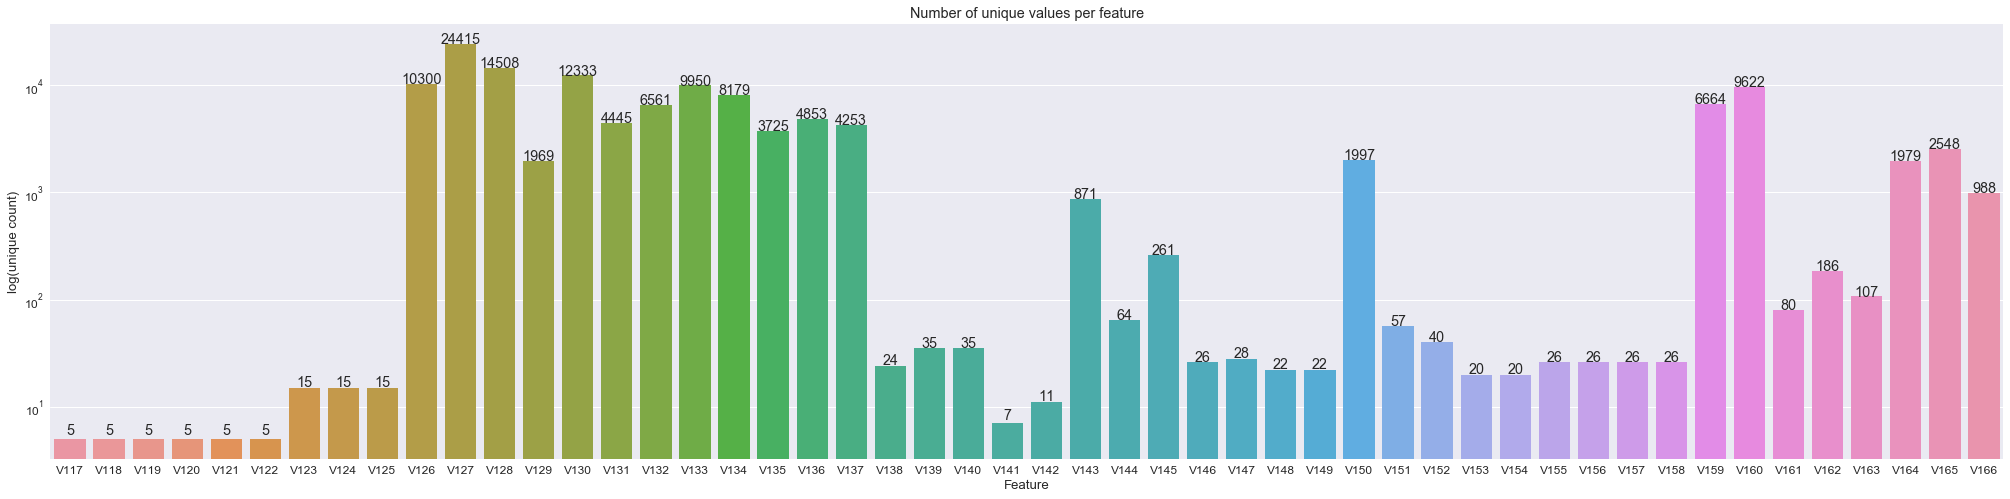

In [32]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[170:220])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            uniq,
            ha="center") 

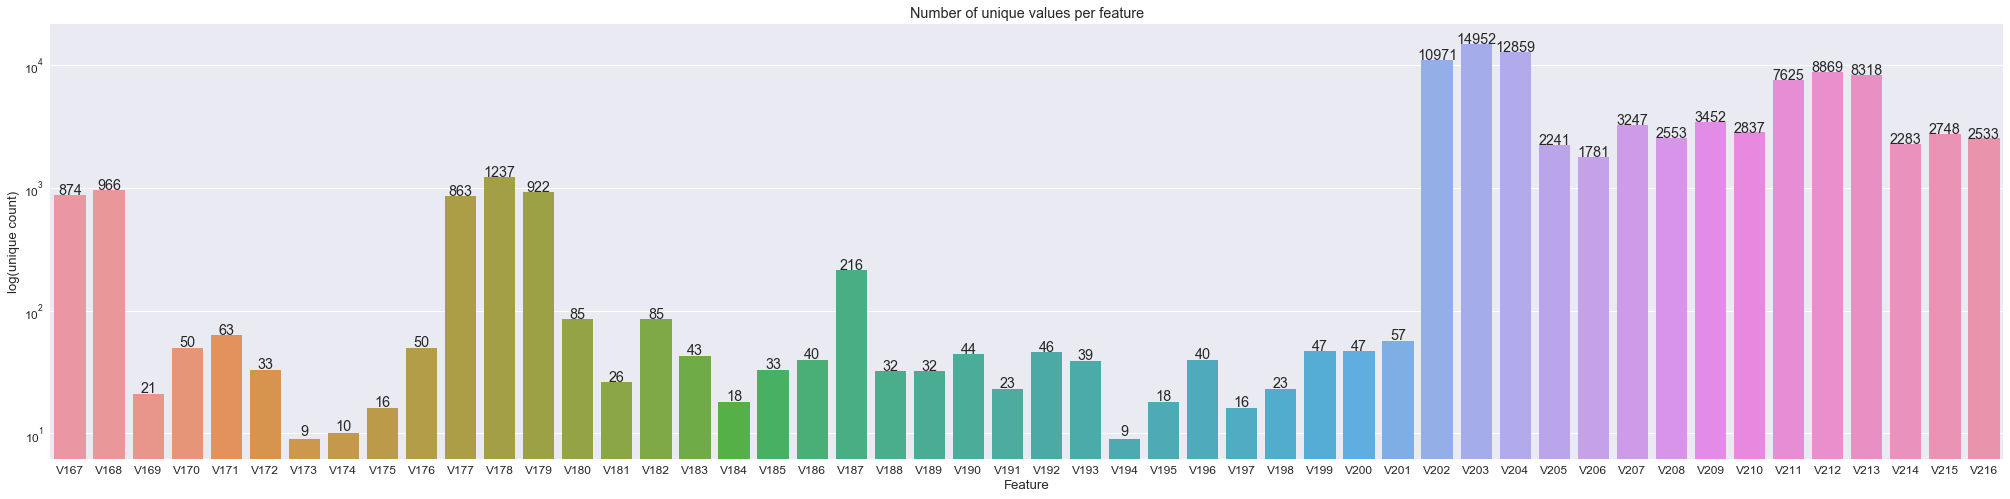

In [34]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[220:270])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            uniq,
            ha="center") 

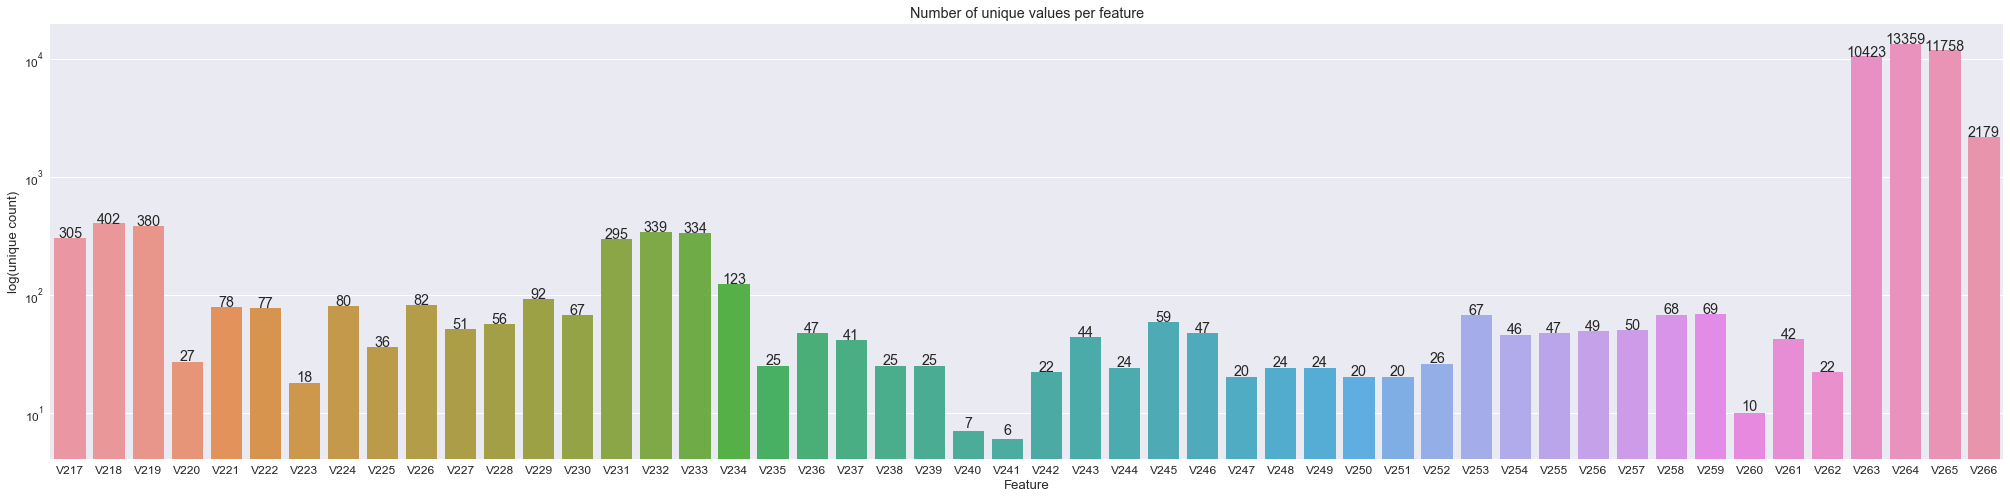

In [35]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[270:320])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            uniq,
            ha="center") 

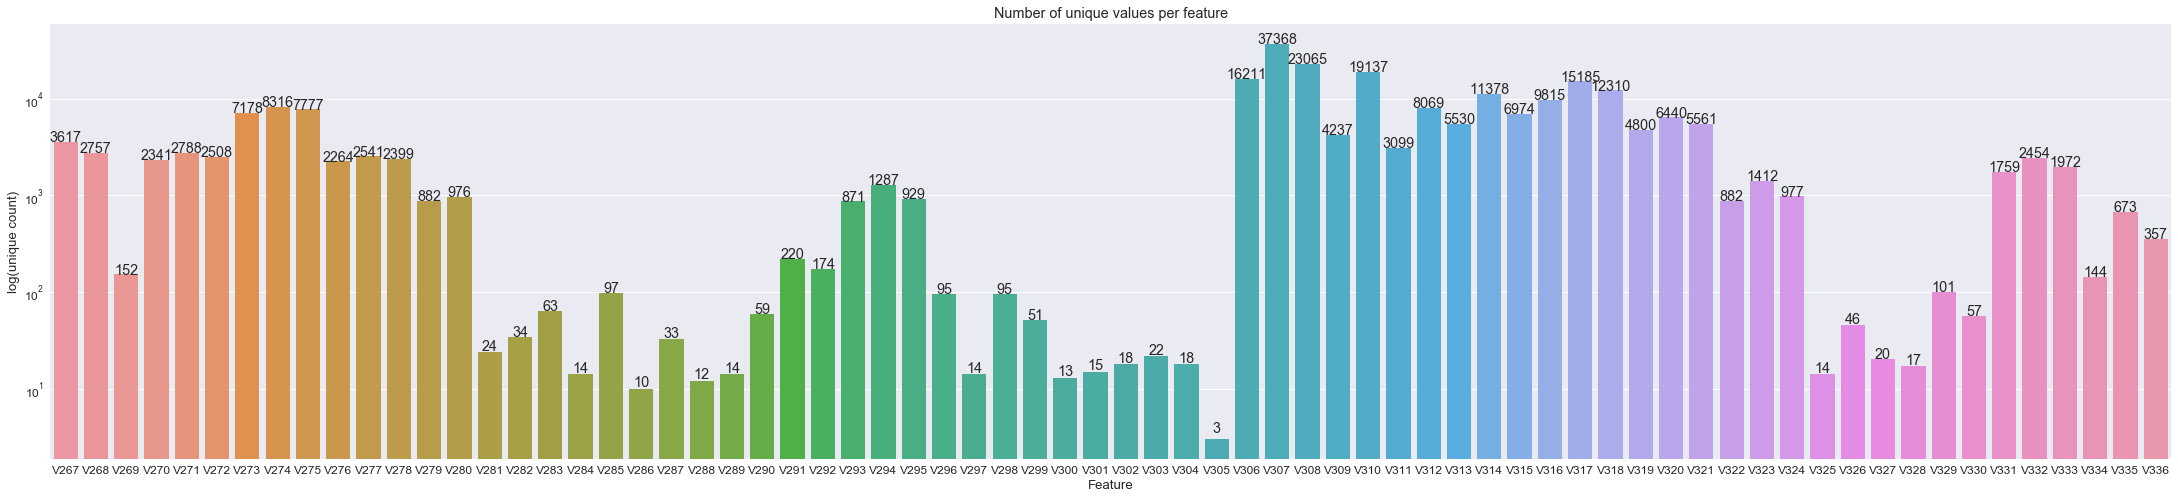

In [36]:
plt.figure(figsize=(38, 8))
v_features = list(train_transaction.columns[320:390])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            uniq,
            ha="center") 

## id_code

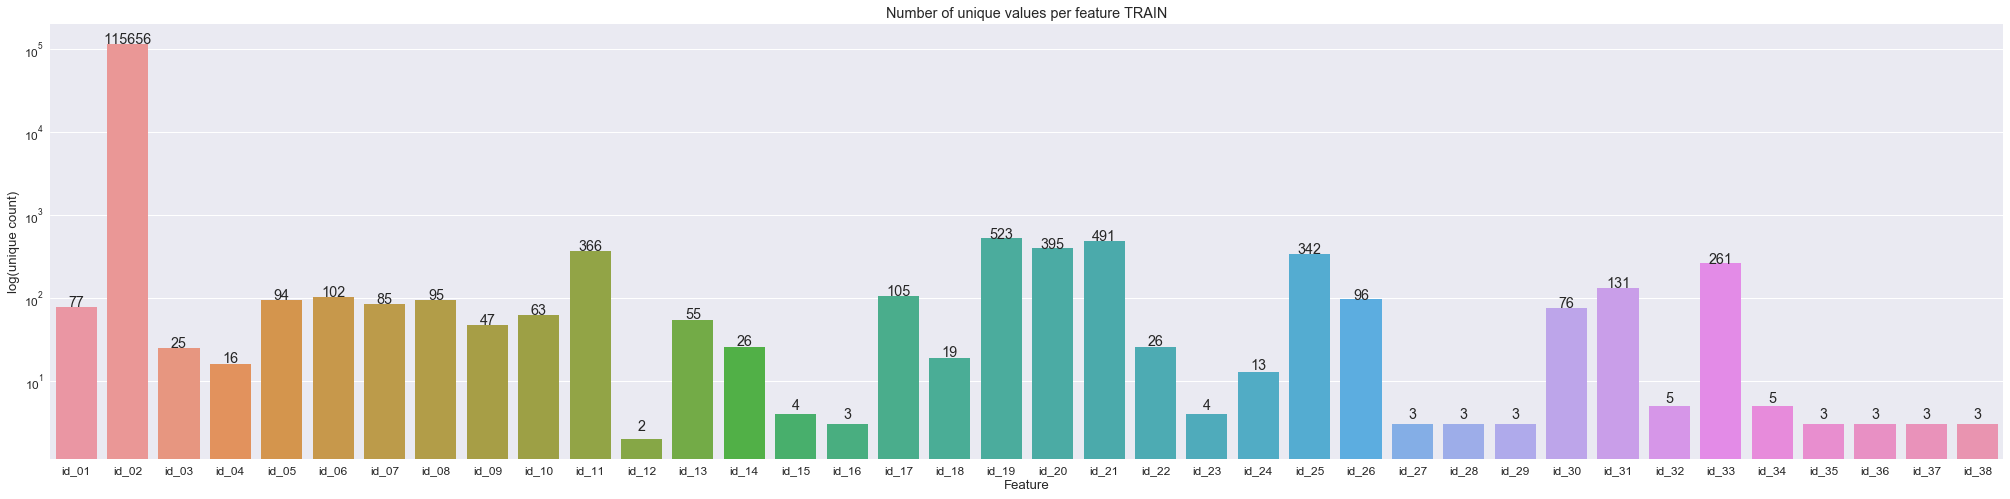

In [38]:
plt.figure(figsize=(35, 8))
features = list(train_identity.columns[0:38])
uniques = [len(train_identity[col].unique()) for col in features]
sns.set(font_scale=1.2)
ax = sns.barplot(features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            uniq,
            ha="center") 

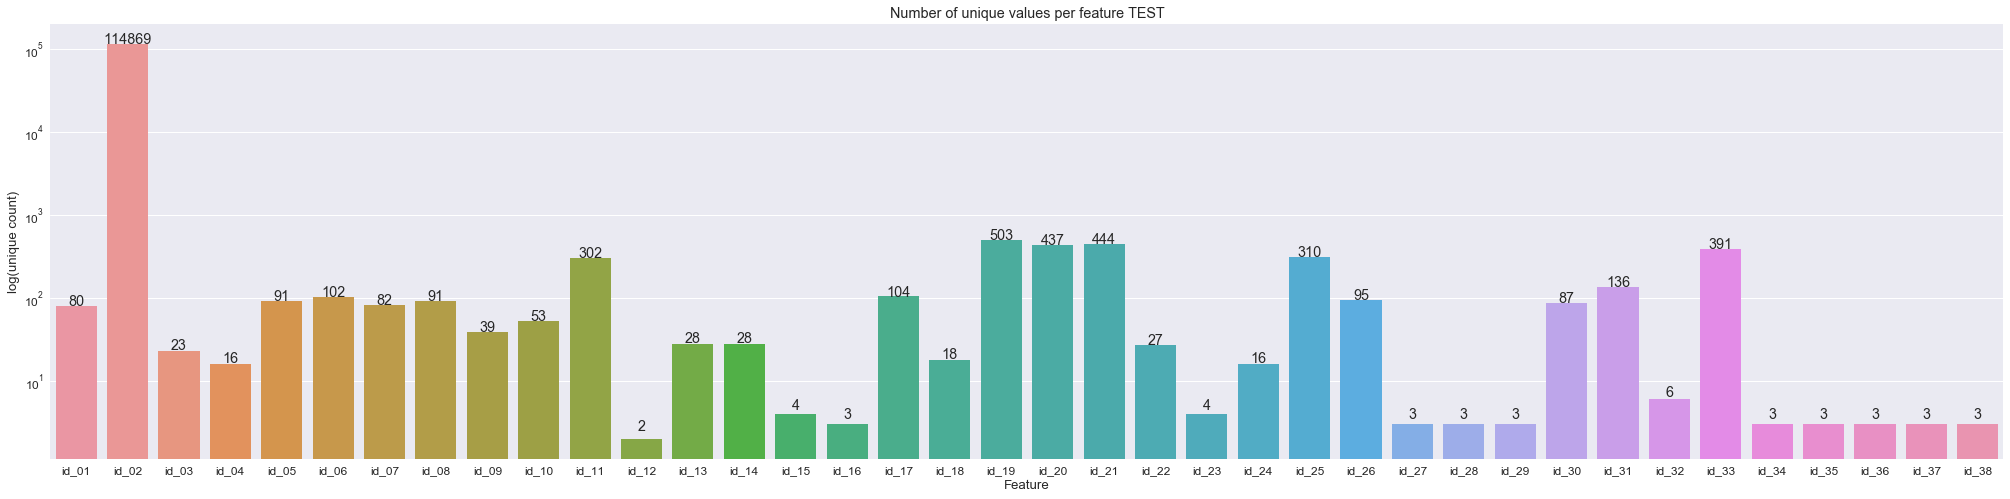

In [39]:
plt.figure(figsize=(35, 8))
features = list(test_identity.columns[0:38])
uniques = [len(test_identity[col].unique()) for col in features]
sns.set(font_scale=1.2)
ax = sns.barplot(features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            uniq,
            ha="center") 

## Categorical Features

### ProductCD

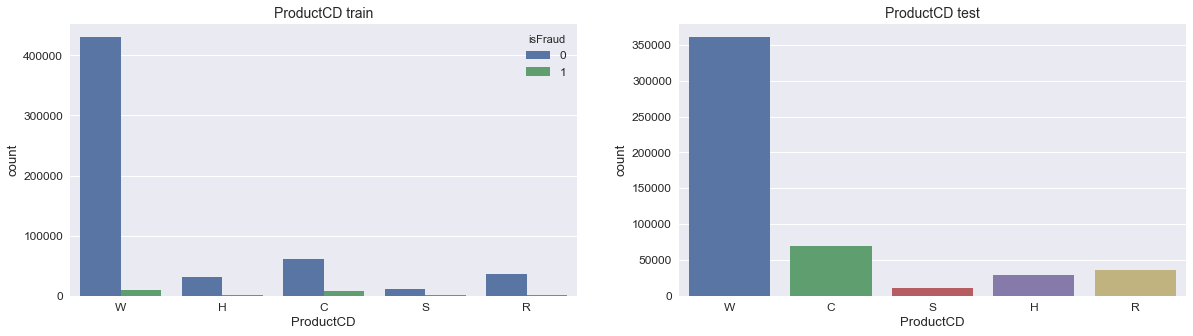

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train_transaction)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test_transaction)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

### Device Type & Device Info

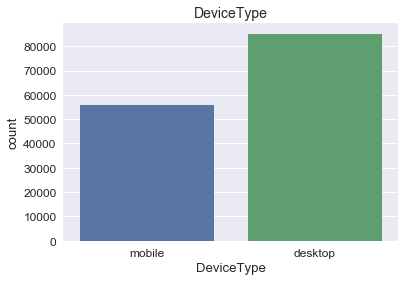

In [41]:
ax = sns.countplot(x="DeviceType", data=train_identity)
ax.set_title('DeviceType', fontsize=14)
plt.show()

### Device information

In [42]:
print ("Unique Devices = ",train_identity['DeviceInfo'].nunique())
train_identity['DeviceInfo'].value_counts().head()

Unique Devices =  1786


Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
Name: DeviceInfo, dtype: int64

### Card

In [43]:
cards = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
for i in cards:
    print ("Unique ",i, " = ",train_transaction[i].nunique())

Unique  card1  =  13553
Unique  card2  =  500
Unique  card3  =  114
Unique  card4  =  4
Unique  card5  =  119
Unique  card6  =  4


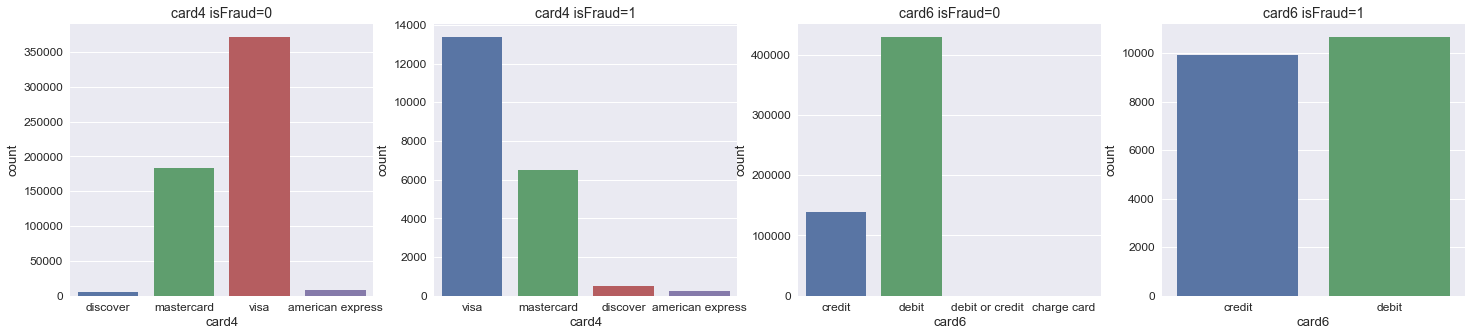

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

sns.countplot(x="card4", ax=ax[0], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[0].set_title('card4 isFraud=0', fontsize=14)
sns.countplot(x="card4", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('card4 isFraud=1', fontsize=14)
sns.countplot(x="card6", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('card6 isFraud=0', fontsize=14)
sns.countplot(x="card6", ax=ax[3], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[3].set_title('card6 isFraud=1', fontsize=14)
plt.show()

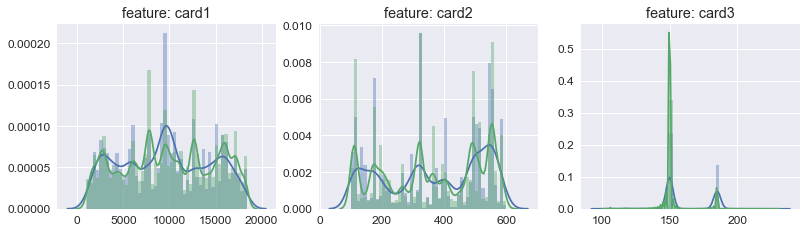

In [57]:
cards = train_transaction.iloc[:,4:7].columns

plt.figure(figsize=(18,8*4))
gs = gridspec.GridSpec(8, 4)
for i, cn in enumerate(cards):
    ax = plt.subplot(gs[i])
    sns.distplot(train_transaction.loc[train_transaction['isFraud'] == 1][cn].dropna(), bins=50)
    sns.distplot(train_transaction.loc[train_transaction['isFraud'] == 0][cn].dropna(), bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

In [8]:
card_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

pd.concat([train_transaction[card_features].isna().sum(), test_transaction[card_features].isna().sum()], axis=1).rename(columns={0: 'train_NaNs', 1: 'test_NaNs'})


,train_NaNs,test_NaNs
card1,0,0
card2,8933,8654
card3,1565,3002
card4,1577,3086
card5,4259,4547
card6,1571,3007


In [9]:
pd.concat([train_transaction[card_features].isna().sum() / train_transaction.shape[0], test_transaction[card_features].isna().sum() / test_transaction.shape[0]], axis=1).rename(columns={0: 'train_NaNs_%', 1: 'test_NaNs_%'})


,train_NaNs_%,test_NaNs_%
card1,0.000000,0.000000
card2,0.015127,0.017079
card3,0.002650,0.005925
card4,0.002670,0.006090
card5,0.007212,0.008974
card6,0.002660,0.005935


In [12]:
def count_uniques(train, test, pair):
    unique_train = []
    unique_test = []

    for value in train[pair[0]].unique():
        unique_train.append(train[pair[1]][train[pair[0]] == value].value_counts().shape[0])

    for value in test[pair[0]].unique():
        unique_test.append(test[pair[1]][test[pair[0]] == value].value_counts().shape[0])

    pair_values_train = pd.Series(data=unique_train, index=train[pair[0]].unique())
    pair_values_test = pd.Series(data=unique_test, index=test[pair[0]].unique())
    
    return pair_values_train, pair_values_test

In [26]:
def nans_distribution(train, test, unique_train, unique_test, pair):
    train_nans_per_category = []
    test_nans_per_category = []

    for value in unique_train.unique():
        train_nans_per_category.append(train[train[pair[0]].isin(list(unique_train[unique_train == value].index))][pair[1]].isna().sum())

    for value in unique_test.unique():
        test_nans_per_category.append(test[test[pair[0]].isin(list(unique_test[unique_test == value].index))][pair[1]].isna().sum())

    pair_values_train = pd.Series(data=train_nans_per_category, index=unique_train.unique())
    pair_values_test = pd.Series(data=test_nans_per_category, index=unique_test.unique())
    
    return pair_values_train, pair_values_test


In [ ]:
def fill_card_nans(train, test, pair_values_train, pair_values_test, pair):
    print(f'In train{[pair[1]]} there are {train[pair[1]].isna().sum()} NaNs' )
    print(f'In test{[pair[1]]} there are {test[pair[1]].isna().sum()} NaNs' )

    print('Filling train...')
    
    for value in pair_values_train[pair_values_train == 1].index:
        train[pair[1]][train[pair[0]] == value] = train[pair[1]][train[pair[0]] == value].value_counts().index[0]
        
    print('Filling test...')

    for value in pair_values_test[pair_values_test == 1].index:
        test[pair[1]][test[pair[0]] == value] = test[pair[1]][test[pair[0]] == value].value_counts().index[0]
        
    print(f'In train{[pair[1]]} there are {train[pair[1]].isna().sum()} NaNs' )
    print(f'In test{[pair[1]]} there are {test[pair[1]].isna().sum()} NaNs' )
    
    return train, test

In [ ]:
def fill_pairs(train, test, pairs):
    for pair in pairs:

        unique_train = []
        unique_test = []

        print(f'Pair: {pair}')
        print(f'In train{[pair[1]]} there are {train[pair[1]].isna().sum()} NaNs' )
        print(f'In test{[pair[1]]} there are {test[pair[1]].isna().sum()} NaNs' )

        for value in train[pair[0]].unique():
            unique_train.append(train[pair[1]][train[pair[0]] == value].value_counts().shape[0])

        for value in test[pair[0]].unique():
            unique_test.append(test[pair[1]][test[pair[0]] == value].value_counts().shape[0])

        pair_values_train = pd.Series(data=unique_train, index=train[pair[0]].unique())
        pair_values_test = pd.Series(data=unique_test, index=test[pair[0]].unique())
        
        print('Filling train...')

        for value in pair_values_train[pair_values_train == 1].index:
            train.loc[train[pair[0]] == value, pair[1]] = train.loc[train[pair[0]] == value, pair[1]].value_counts().index[0]

        print('Filling test...')

        for value in pair_values_test[pair_values_test == 1].index:
            test.loc[test[pair[0]] == value, pair[1]] = test.loc[test[pair[0]] == value, pair[1]].value_counts().index[0]

        print(f'In train{[pair[1]]} there are {train[pair[1]].isna().sum()} NaNs' )
        print(f'In test{[pair[1]]} there are {test[pair[1]].isna().sum()} NaNs' )
        
    return train, test

### Email Domain

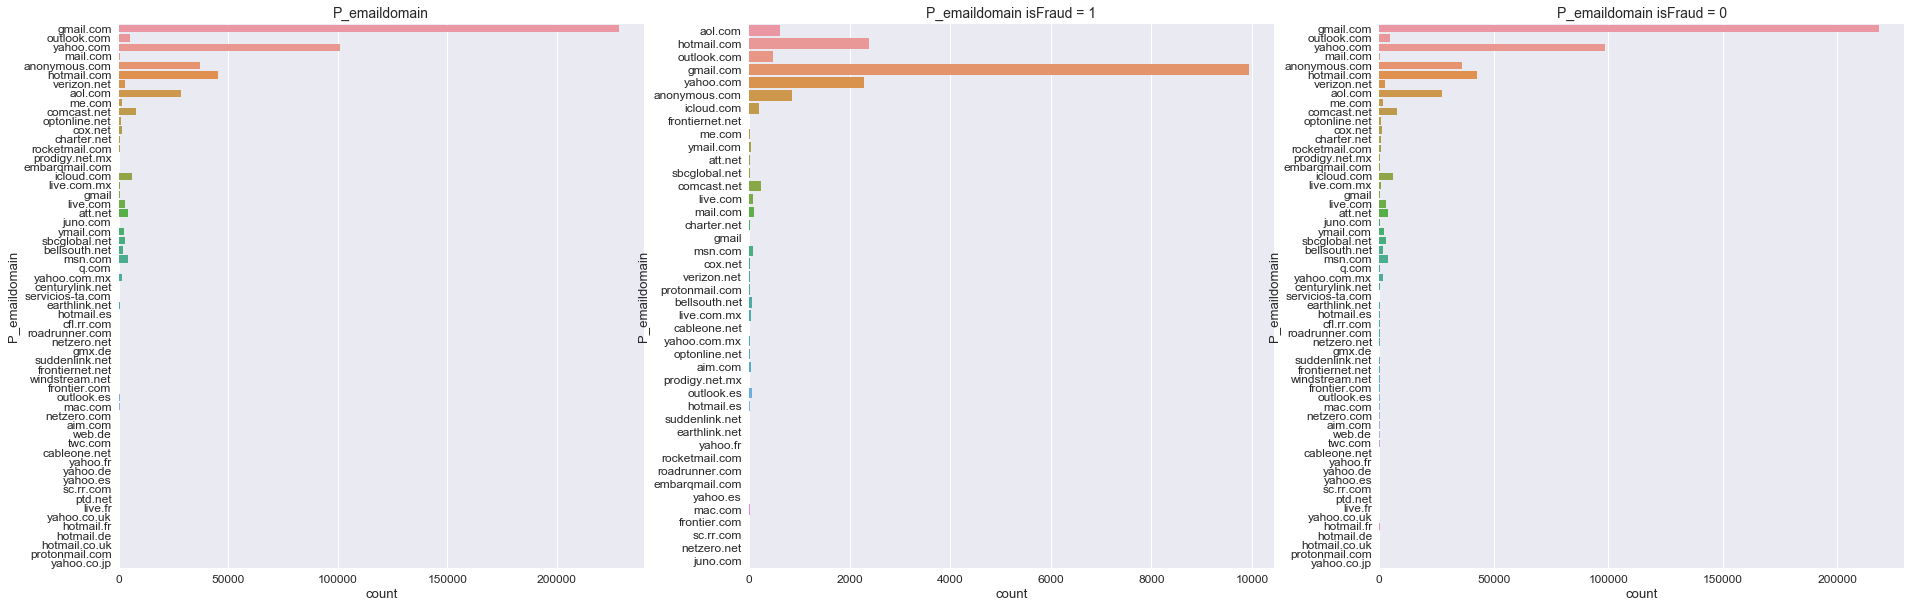

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="P_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('P_emaildomain', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('P_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('P_emaildomain isFraud = 0', fontsize=14)
plt.show()

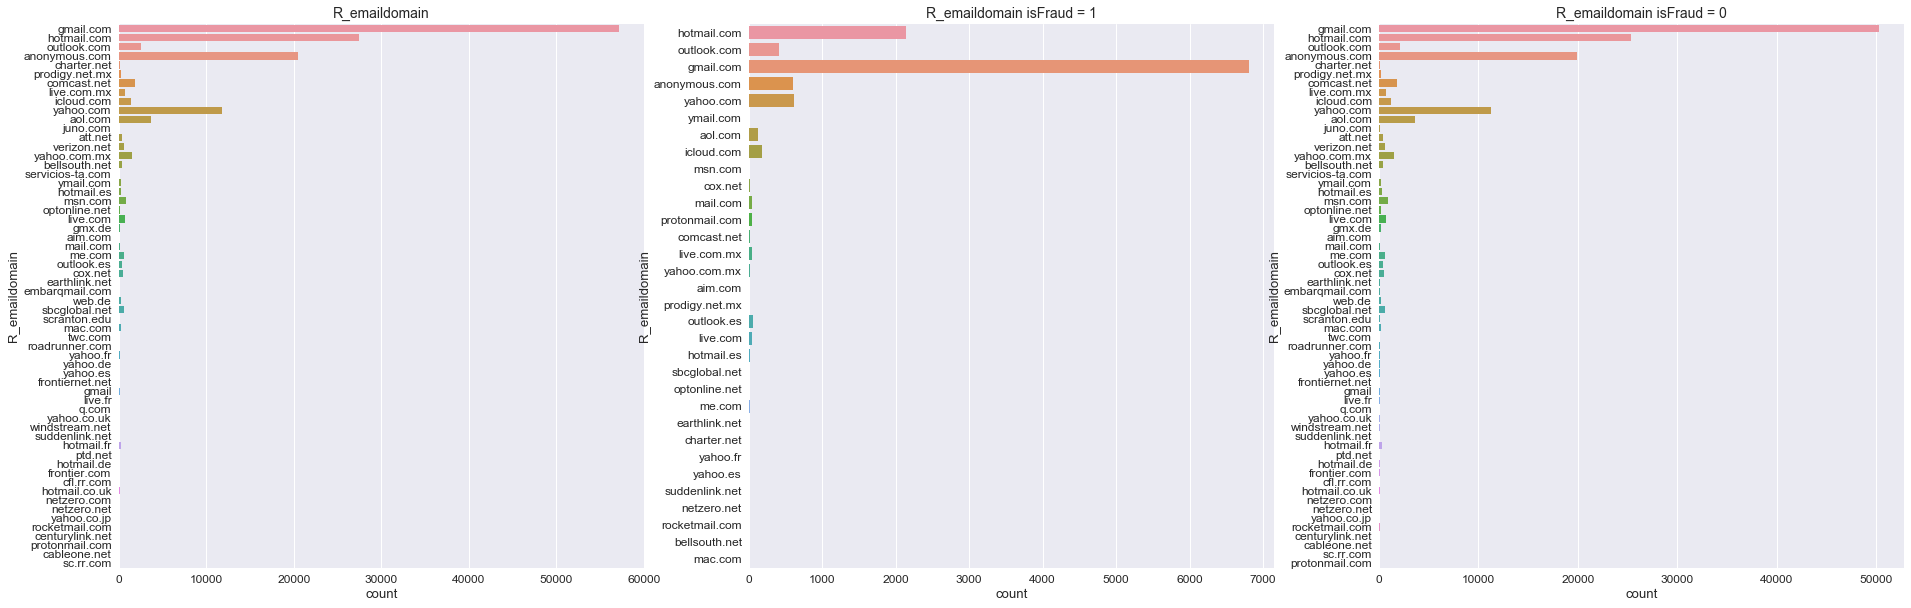

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="R_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('R_emaildomain', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('R_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('R_emaildomain isFraud = 0', fontsize=14)
plt.show()

In [64]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train_transaction[c + '_bin'] = train_transaction[c].map(emails)
    test_transaction[c + '_bin'] = test_transaction[c].map(emails)
    
    train_transaction[c + '_suffix'] = train_transaction[c].map(lambda x: str(x).split('.')[-1])
    test_transaction[c + '_suffix'] = test_transaction[c].map(lambda x: str(x).split('.')[-1])
    
    train_transaction[c + '_suffix'] = train_transaction[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_transaction[c + '_suffix'] = test_transaction[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [5]:
train_transaction["P_parent_emaildomain"] = train_transaction["P_emaildomain"].str.split('.', expand = True)[[0]]

Text(0,0.5,'Fraud Rate')

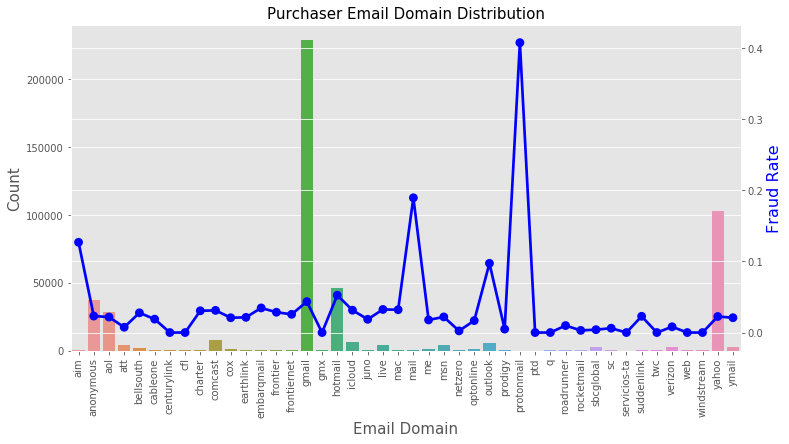

In [6]:
P_emaildomain_fraud_rate = train_transaction.groupby('P_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_parent_emaildomain', data = train_transaction, order = P_emaildomain_fraud_rate.index)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = P_emaildomain_fraud_rate.index, y = P_emaildomain_fraud_rate, color = 'blue')
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

In [16]:
def relax_data(df_train, df_test, col):
    cv1 = pd.DataFrame(df_train[col].value_counts().reset_index().rename({col:'train'},axis=1))
    cv2 = pd.DataFrame(df_test[col].value_counts().reset_index().rename({col:'test'},axis=1))
    cv3 = pd.merge(cv1,cv2,on='index',how='outer')
    factor = len(df_test)/len(df_train)
    cv3['train'].fillna(0,inplace=True)
    cv3['test'].fillna(0,inplace=True)
    cv3['remove'] = False
    cv3['remove'] = cv3['remove'] | (cv3['train'] < len(df_train)/10000)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] < cv3['test']/3)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] > 3*cv3['test'])
    cv3['new'] = cv3.apply(lambda x: x['index'] if x['remove']==False else 0,axis=1)
    cv3['new'],_ = cv3['new'].factorize(sort=True)
    cv3.set_index('index',inplace=True)
    cc = cv3['new'].to_dict()
    df_train[col] = df_train[col].map(cc)
    df_test[col] = df_test[col].map(cc)
    return df_train, df_test

def plot_numerical(feature):
    """
    Plot some information about a numerical feature for both train and test set.
    Args:
        feature (str): name of the column in DataFrame
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
    sns.kdeplot(train_transaction[feature], ax=axes[0], label='Train');
    sns.kdeplot(test_transaction[feature], ax=axes[0], label='Test');

    test_transaction[feature].index += len(train_transaction)
    axes[1].plot(train_transaction[feature], '.', label='Train');
    axes[1].plot(test_transaction[feature], '.', label='Test');
    axes[1].set_xlabel('row index');
    axes[1].legend()
    test_transaction[feature].index -= len(train_transaction)

    fig.suptitle(feature, fontsize=18);
    axes[0].set_title('Train/Test KDE distribution');
    axes[1].set_title('Index versus value: Train/Test distribution');

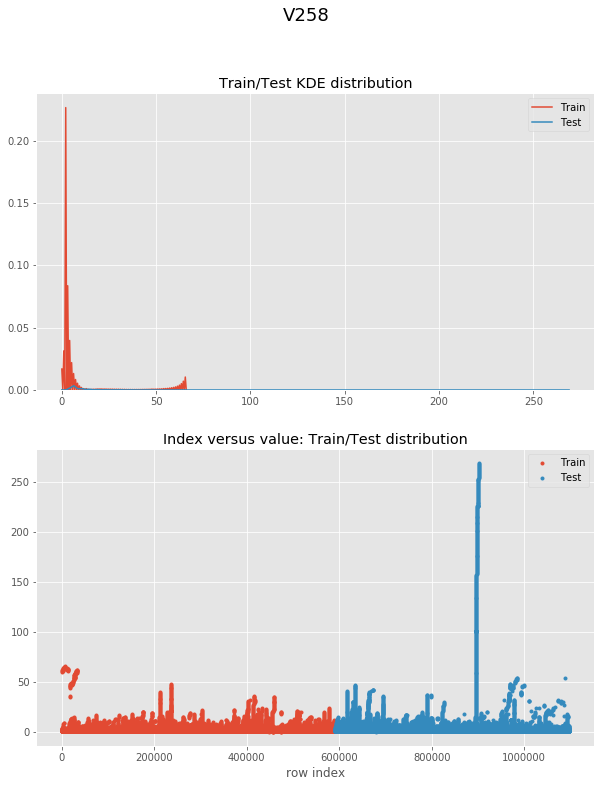

In [17]:
plot_numerical('V258')

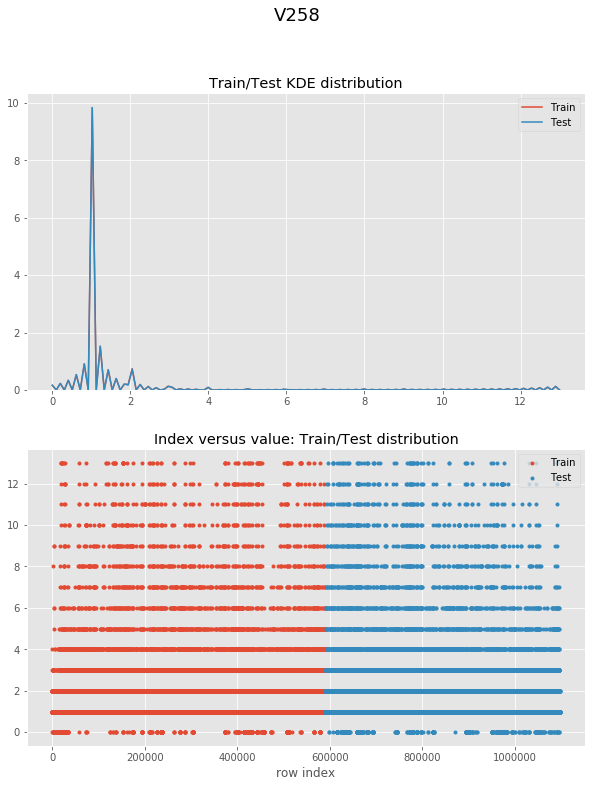

In [18]:
train_transaction, test_transaction = relax_data(train_transaction, test_transaction, 'V258')
plot_numerical('V258')

In [31]:
pd.options.display.max_colwidth =300
col_na_group= train_transaction_na.groupby('percent_missing')['column_name'].unique().reset_index()
num_columns=[]
for i in range(len(col_na_group)):
    num_columns.append(len(col_na_group.column_name[i]))
col_na_group['num_columns']=num_columns
col_na_group = col_na_group.loc[(col_na_group['num_columns']>1) & (col_na_group['percent_missing']>0),].sort_values(by='percent_missing',ascending=False).reset_index()
col_na_group

NameError: name 'train_transaction_na' is not defined

## Reference

- [IEEE Fraud Detection](https://www.kaggle.com/jesucristo/fraud-complete-eda)
- [Cleaning P_emaildomain and R_emaildomain](https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654)
- [EDA for CIS Fraud Detection](https://www.kaggle.com/nroman/eda-for-cis-fraud-detection)
- [Filling card NaNs](https://www.kaggle.com/grazder/filling-card-nans)